In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import networkx as nx
from IPython.display import clear_output

sns.set_style(style="whitegrid")

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [5]:
DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["AVAXUSDT"]
SLEEP_INTERVAL = 1
DOM = 10

In [6]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [7]:
symbols = ds.fetch_future_symbols()
symbol = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [9]:
def plot_order_book(bids, asks, highlight_best=True):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    sns.lineplot(x=bids_df['price'], y=bids_df['cum_quantity'], label='Bids', color='green', linewidth=2)
    sns.lineplot(x=asks_df['price'], y=asks_df['cum_quantity'], label='Asks', color='red', linewidth=2)

    bid_imbalance = bids_df['cum_quantity'].max() - asks_df['cum_quantity'].mean()
    ask_imbalance = asks_df['cum_quantity'].max() - bids_df['cum_quantity'].mean()
    imbalance_threshold = (bid_imbalance + ask_imbalance) / 2

    plt.axhline(imbalance_threshold, color='orange', linestyle='--', label=f'Imbalance Threshold: {imbalance_threshold:.2f}')

    plt.fill_between(bids_df['price'], bids_df['cum_quantity'], color='green', alpha=0.3, step='mid')
    plt.fill_between(asks_df['price'], asks_df['cum_quantity'], color='red', alpha=0.3, step='mid')

    if highlight_best:
        best_bid = bids_df['price'].iloc[0]
        best_ask = asks_df['price'].iloc[0]

        plt.axvline(best_bid, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
        plt.axvline(best_ask, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

        mid_price = (best_bid + best_ask) / 2
        plt.axvline(mid_price, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)

    vwap_bid = (bids_df['price'] * bids_df['quantity']).sum() / bids_df['quantity'].sum()
    vwap_ask = (asks_df['price'] * asks_df['quantity']).sum() / asks_df['quantity'].sum()

    plt.axvline(vwap_bid, color='darkgreen', linestyle=':', label=f'VWAP Bid: {vwap_bid:.2f}', linewidth=1.2)
    plt.axvline(vwap_ask, color='darkred', linestyle=':', label=f'VWAP Ask: {vwap_ask:.2f}', linewidth=1.2)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Cumulative Quantity', fontsize=12)
    plt.title('Order Book Depth Chart', fontsize=14)

    plt.legend(loc="upper right")

    plt.show()

In [10]:
def plot_order_book(bids, asks):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    best_bid = bids_df['price'].iloc[0]
    best_ask = asks_df['price'].iloc[0]


    mid_price = (best_bid + best_ask) / 2

    spread = best_ask - best_bid
    mid_spread = spread / 2

    bids_df['relative_price'] = bids_df['price'] - best_bid - mid_spread
    asks_df['relative_price'] = asks_df['price'] - best_ask + mid_spread

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    plt.bar(bids_df['relative_price'], -bids_df['cum_quantity'], color='green', label='Bids', width=spread/2, alpha=0.9)
    plt.bar(asks_df['relative_price'], asks_df['cum_quantity'], color='red', label='Asks', width=spread/2, alpha=0.9)

    plt.axvline(-mid_spread, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
    plt.axvline(0, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)
    plt.axvline(mid_spread, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

    plt.xlabel('Price Relative to Best Bid (Spread Divider)', fontsize=12)
    plt.ylabel('Cumulative Quantity (Depth)', fontsize=12)
    plt.title('Order Book Depth Bar Chart', fontsize=14)

    plt.legend(loc="upper right")
    plt.show()

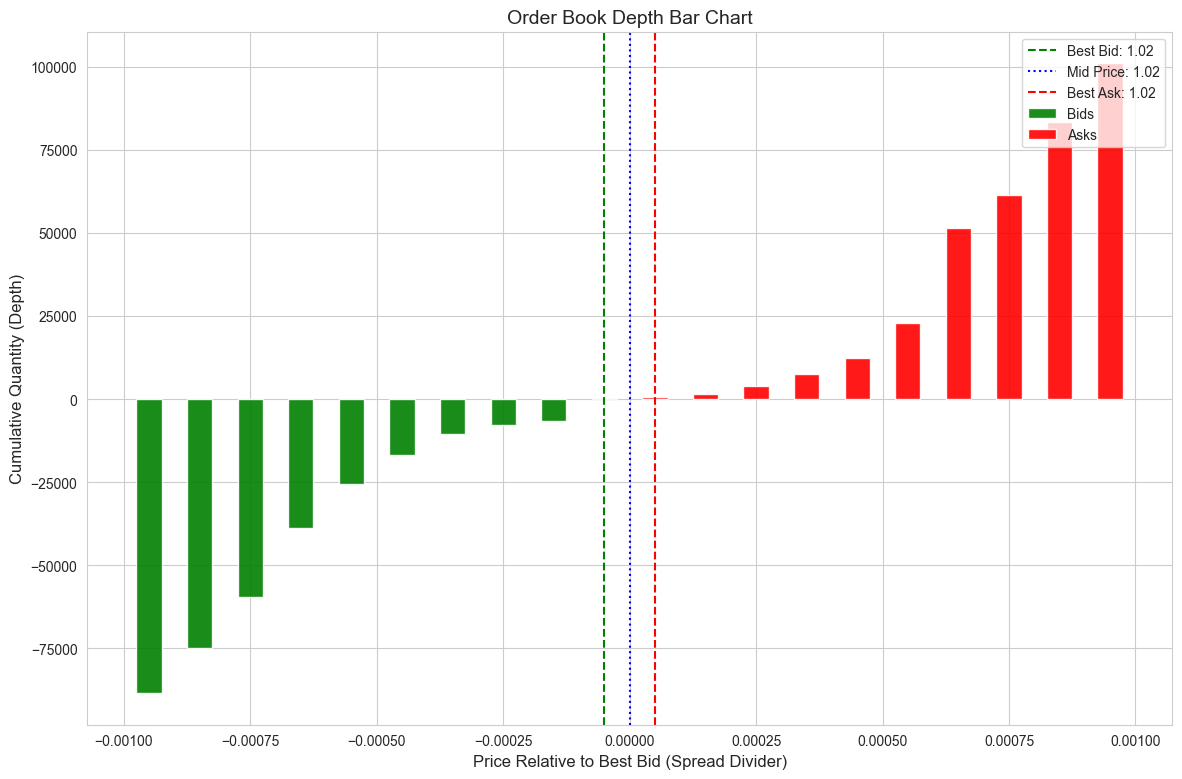

KeyboardInterrupt: 

In [211]:
while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    plot_order_book(np.array(bids), np.array(asks))

    time.sleep(SLEEP_INTERVAL)

In [34]:
def calculate_order_slices(symbol, total_size):
    x_min = symbol.min_position_size
    alpha = np.random.uniform(1.3, 1.5)

    while True:
        u = np.random.rand()

        order_size = x_min * (1 - u) ** (-1 / (alpha - 1))

        order_size = min(order_size, total_size)

        yield order_size

In [35]:
def plot_order_sizes(order_sizes):
    plt.figure(figsize=(10, 6))
    sns.histplot(order_sizes, bins=30, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6)
    plt.title('Distribution of Sampled Order Sizes')
    plt.xlabel('Order Size')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

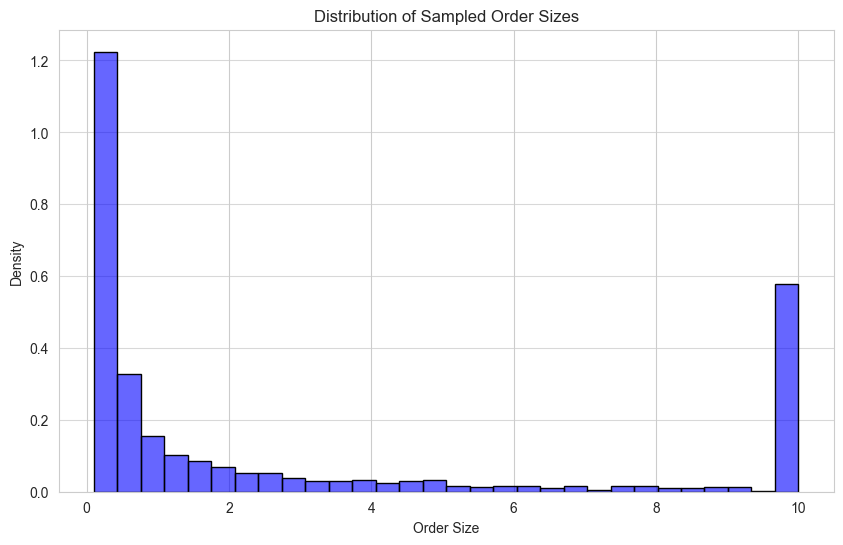

In [36]:
total_size = 10
num_samples = 1000

order_generator = calculate_order_slices(symbol=symbol[0], total_size=total_size)
order_sizes = [next(order_generator) for _ in range(num_samples)]

plot_order_sizes(order_sizes)


In [8]:
SLEEP_INTERVAL = 8
ONE_HOUR = 3600
MULTI = 8
ORDER_BOOK_FILE = f'order_book_{symbol[0].name}_8h.csv'

In [144]:
columns = ['timestamp'] + [item for i in range(1, DOM + 1) for item in [
    f'Ask {i} Price', 
    f'Ask {i} Size', 
    f'Bid {i} Price', 
    f'Bid {i} Size'
]]

df = pd.DataFrame(columns=columns)

start_time = time.time()
end_time = ONE_HOUR * MULTI

while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    row = [timestamp]

    for i in range(DOM):
        row.extend([asks[i][0], asks[i][1], bids[i][0], bids[i][1]])

    df.loc[len(df)] = row

    time.sleep(SLEEP_INTERVAL)
    
    if time.time() - start_time > end_time:
        break

df.to_csv(ORDER_BOOK_FILE, index=False)

df.head()

Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=AVAXUSDT&category=linear&limit=10. Retrying...


,timestamp,Ask 1 Price,Ask 1 Size,Bid 1 Price,Bid 1 Size,Ask 2 Price,Ask 2 Size,Bid 2 Price,Bid 2 Size,Ask 3 Price,...,Bid 8 Price,Bid 8 Size,Ask 9 Price,Ask 9 Size,Bid 9 Price,Bid 9 Size,Ask 10 Price,Ask 10 Size,Bid 10 Price,Bid 10 Size
0,1.730506e+12,24.790,1282.4,24.785,196.4,24.795,2944.1,24.780,1304.4,24.800,...,24.750,1398.2,24.830,972.9,24.745,4467.5,24.835,2742.8,24.740,2112.8
1,1.730506e+12,24.790,1809.1,24.785,46.7,24.795,2554.8,24.780,1247.7,24.800,...,24.750,1225.5,24.830,972.9,24.745,2230.3,24.835,2742.8,24.740,2790.7
2,1.730506e+12,24.780,835.1,24.775,824.8,24.785,3496.2,24.770,2121.0,24.790,...,24.740,2759.5,24.820,762.1,24.735,3504.1,24.825,1142.3,24.730,1754.7
3,1.730506e+12,24.780,866.3,24.775,882.7,24.785,3496.5,24.770,2203.3,24.790,...,24.740,2759.5,24.820,710.3,24.735,3504.1,24.825,1098.0,24.730,1754.7
4,1.730506e+12,24.785,1331.3,24.780,626.8,24.790,2823.3,24.775,1976.4,24.795,...,24.745,1483.5,24.825,1098.0,24.740,2759.5,24.830,3240.4,24.735,3519.9


In [9]:
def fe(df, k=8):
    df = df.copy()
   
    df['P'] = (df['Ask 1 Price'] + df['Bid 1 Price']) / 2
    df['PS'] = (df['Ask 1 Price'] - df['Bid 1 Price'])
    
    df['P+'] = df['P'].rolling(window=k).mean()
    df['P+'] = df['P+'].fillna(df['P'])

    df['d'] = (df['P+'] - df['P']) / df['P']
    
    df['R'] = (df['P'].shift(-1) - df['P']) / df['P']
    df['R'] = df['R'].fillna(0)
    
    df['D_B'] = df[[f'Bid {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)
    df['D_A'] = df[[f'Ask {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)

    df['DI'] = (df['D_B'] - df['D_A']) / (df['D_B'] + df['D_A'])

    df['BI'] = ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) - (df[f'Ask {DOM} Price'] - df['Ask 1 Price'])) / ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) + (df[f'Ask {DOM} Price'] - df['Ask 1 Price']))

    df['VI'] = (df['Bid 1 Size'] - df['Ask 1 Size']) / (df['Bid 1 Size'] + df['Ask 1 Size'])

    df['M'] = (df['Bid 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Ask 1 Price'] + (df['Ask 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Bid 1 Price']

    return df[['timestamp', 'P', 'PS', 'R', 'DI', 'BI', 'VI', 'M', 'd']]

df = pd.read_csv(ORDER_BOOK_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df_fe = fe(df)

df_fe.head()

,timestamp,P,PS,R,DI,BI,VI,M,d
0,2024-11-01 23:58:51.646,24.7875,0.005,0.000000,0.164004,0.000000e+00,-0.734379,24.785664,0.0
1,2024-11-01 23:59:00.147,24.7875,0.005,-0.000403,0.112261,0.000000e+00,-0.949671,24.785126,0.0
2,2024-11-01 23:59:08.746,24.7775,0.005,0.000000,0.147797,0.000000e+00,-0.006205,24.777484,0.0
3,2024-11-01 23:59:17.047,24.7775,0.005,0.000202,0.151567,0.000000e+00,0.009377,24.777523,0.0
4,2024-11-01 23:59:25.246,24.7825,0.005,0.000000,0.099785,3.947460e-14,-0.359788,24.781601,0.0


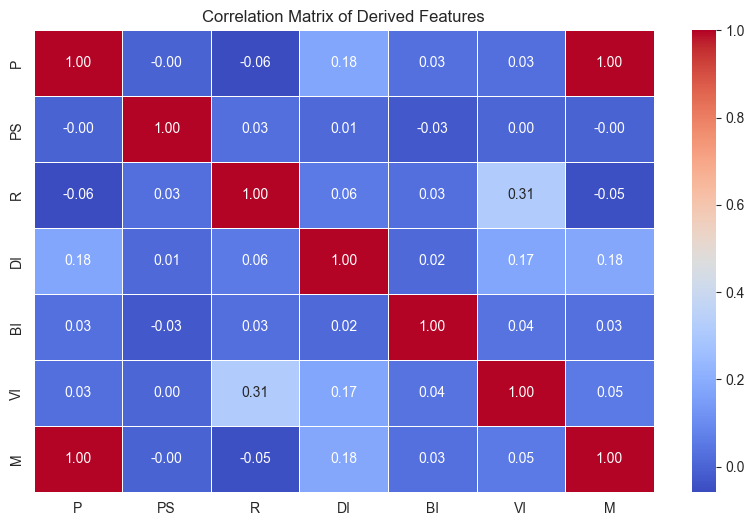

In [10]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 6))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Derived Features")
    plt.show()

plot_correlation_matrix(df_fe.drop(columns=['timestamp', 'd']))

In [11]:
def label_data(df, alpha):
    df = df.copy()
    df['y'] = np.where(df['d'] > alpha, 1, np.where(df['d'] < -alpha, -1, 0))
    return df

def plot_label_distribution(df):
    label_counts = df['y'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})
    
    sns.barplot(ax=axes[0], x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", dodge=False)
    axes[0].set_title('Class Distribution of Labels')
    axes[0].set_xlabel('Class Labels')
    axes[0].set_ylabel('Frequency')
    axes[0].legend(title="Labels", loc="upper right")
    
    sns.kdeplot(ax=axes[1], data=df, x='y', fill=True, alpha=0.5)
    axes[1].set_title('KDE Plot of Label Density')
    axes[1].set_xlabel('Class Labels')
    axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [15]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

best_alpha = None
best_imbalance_ratio = float('inf')

BIG_NUM = 1e10
NEUTRAL_PENALTY_WEIGHT = 0.15

def calculate_imbalance_ratio(label_counts):
    positive_count = label_counts.get(1, 0)
    negative_count = label_counts.get(-1, 0)
    neutral_count = label_counts.get(0, 0)
    total_count = positive_count + negative_count + neutral_count
    
    if total_count == 0:
        return BIG_NUM

    weight_pos = positive_count / total_count
    weight_neg = negative_count / total_count
    weight_neutral = neutral_count / total_count
    
    neutral_penalty = weight_neutral ** 2

    if positive_count == 0 or negative_count == 0:
        balance_penalty = BIG_NUM
    else:
        balance_penalty = (abs(weight_pos - weight_neg)) ** 2
    
    return min(balance_penalty + NEUTRAL_PENALTY_WEIGHT * neutral_penalty, BIG_NUM)

search_space = [Real(1e-6, 1e-2, "log-uniform", name="alpha")]

@use_named_args(search_space)
def optimize_alpha(alpha):
    df_l = label_data(df_fe, alpha)
    label_counts = df_l['y'].value_counts()
    imbalance_ratio = calculate_imbalance_ratio(label_counts)
    
    if np.isinf(imbalance_ratio) or np.isnan(imbalance_ratio):
        imbalance_ratio = BIG_NUM

    return imbalance_ratio

result = gp_minimize(
    func=optimize_alpha,
    dimensions=search_space,
    n_calls=50,
    n_random_starts=5,
    acq_func="EI",
    random_state=seed
)

best_alpha = result.x[0]
best_imbalance_ratio = result.fun

print(f"Best alpha: {best_alpha}")
print(f"Best imbalance ratio: {best_imbalance_ratio}")

Best alpha: 7.085175249502597e-06
Best imbalance ratio: 0.0005342211530562158


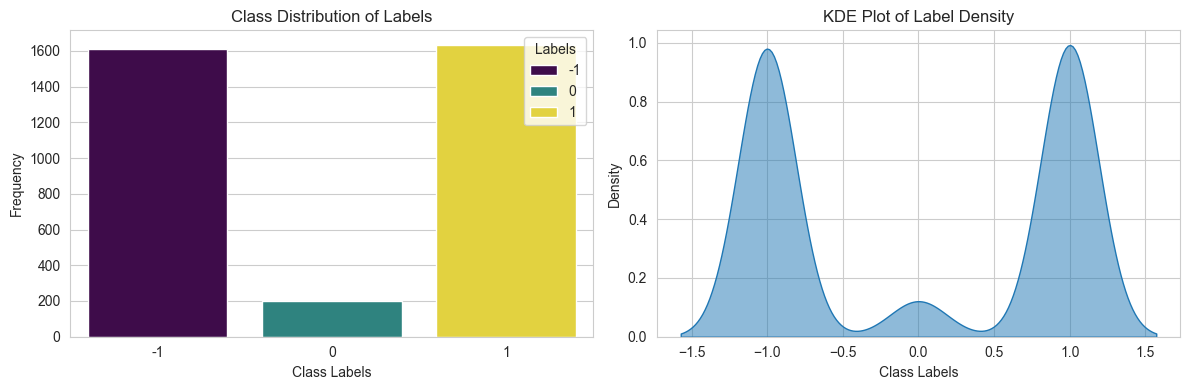

In [16]:
df_l = label_data(df_fe, best_alpha)

plot_label_distribution(df_l)

In [17]:
k = 10
EPS = np.finfo(float).eps

def normalize(X, y, features):
    X_normalized = X.copy()

    for col in features:
        rolling_mean = X[col].rolling(window=k).mean()
        rolling_std = X[col].rolling(window=k).std()
        X_normalized[col] = (X[col] - rolling_mean) / (rolling_std + EPS)

    X_normalized = X_normalized.dropna()
    y = y.loc[X_normalized.index]

    return X_normalized, y

In [18]:
from sklearn.calibration import expit, label_binarize
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, hamming_loss
from imblearn.under_sampling import NeighbourhoodCleaningRule

def sigmoid_fn(preds):
    m, c = np.polyfit(preds, np.log(preds / (1 - preds)), 1)
    return expit(m * preds + c)

def sigmoid_calibration(y_proba):
    return np.apply_along_axis(sigmoid_fn, 0, y_proba)

def isotonic_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        calibrator = IsotonicRegression(out_of_bounds="clip")
        calibrator.fit(class_preds, y_binarized[:, i])
        calibrated_probs[:, i] = calibrator.predict(class_preds)

    return calibrated_probs

def venn_abers_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        
        calibrator_lower = IsotonicRegression(out_of_bounds="clip")
        calibrator_lower.fit(class_preds, y_binarized[:, i])
        lower_bound = calibrator_lower.predict(class_preds)

        calibrator_upper = IsotonicRegression(out_of_bounds="clip")
        calibrator_upper.fit(1 - class_preds, 1 - y_binarized[:, i])
        upper_bound = 1 - calibrator_upper.predict(1 - class_preds)

        calibrated_probs[:, i] = np.sqrt(lower_bound * upper_bound)

    return calibrated_probs

def calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method):
    if calibration_method == 'venn_abers':
        return venn_abers_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'isotonic':
        return isotonic_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'sigmoid':
        return sigmoid_calibration(y_predict_proba)
    else:
        raise ValueError("Unsupported calibration method.")

def perform_kfold_cv(model, X, y, k_folds=5, calibration_method='venn_abers'):
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    classes = np.unique(y)
    probabilities = np.zeros((len(y), len(classes)))
    predictions = np.zeros(len(y))
    true_labels = np.zeros(len(y))

    for train_index, test_index in kf.split(X, y):
        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

        sampler = NeighbourhoodCleaningRule()

        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_full, y_train_full)

        model.fit(X_train_sampled, y_train_sampled)

        y_predict_proba = model.predict_proba(X_test)

        calibrated_probs = calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method)

        predictions[test_index] = classes[np.argmax(calibrated_probs, axis=1)]
        probabilities[test_index] = calibrated_probs

        true_labels[test_index] = y_test.values

    return predictions, probabilities, true_labels

def calculate_metrics(predictions, probabilities, y_true):
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

    def brier_loss_calc(y_true, pred):
        return ((y_true - pred)**2).mean()

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_true, predictions, average='weighted', zero_division=0)
    brier = brier_loss_calc(y_true, predictions)
    roc_auc = roc_auc_score(y_true_binarized, probabilities, average='weighted', multi_class='ovr')
    hamming = hamming_loss(y_true, predictions)

    return accuracy, precision, recall, f1, brier, roc_auc, hamming

def plot_regime(df, model_name):
    plt.figure(figsize=(16, 8))

    plt.plot(df['timestamp'], df['P'], color='gray', alpha=0.5, label='Feature P')

    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 1), 
                    color='green', alpha=0.3, label='Long')
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == -1), 
                    color='red', alpha=0.3, label='Short')
    
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 0), 
                    color='blue', alpha=0.3, label='Range')

    plt.title(f'({model_name}) P and Regime')
    plt.xlabel('TS')
    plt.ylabel('P')
    plt.legend()
    plt.grid()

    plt.show()

def plot_roc_auc(probabilities, true_labels):
    y_test_bin = label_binarize(true_labels,  classes=np.unique(true_labels))
    
    roc_auc = roc_auc_score(y_test_bin, probabilities, average='macro', multi_class='ovr')

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    plt.figure(figsize=(8, 5))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [19]:
features = ['P', 'PS', 'R', 'DI', 'BI', 'VI', 'M']

X = df_l[features]
y = df_l['y']

X_normalized, y = normalize(X, y, features)

timestamps = pd.to_datetime(df_l.loc[X_normalized.index]['timestamp'])


Accuracy: 0.9272
Precision: 0.9152
Recall: 0.9272
F1 Score: 0.9109
Brier Score: 0.1347
ROC-AUC Score: 0.9832
Hamming: 0.0728


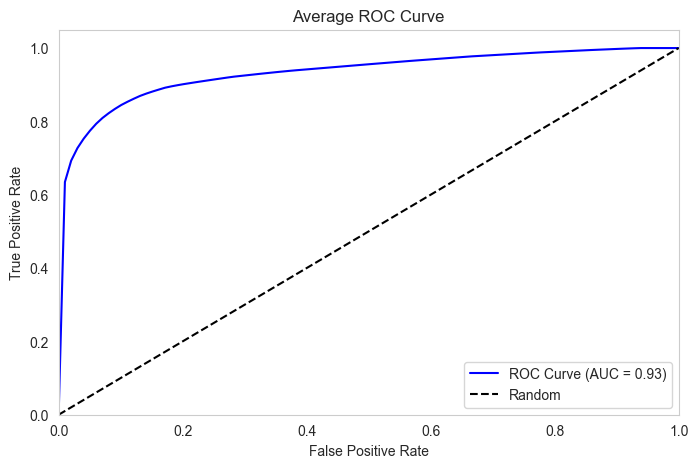

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

k_folds = 5
calibration = 'venn_abers'

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', random_state=seed))

predictions, probabilities, true_labels = perform_kfold_cv(model, X_normalized, y, k_folds, calibration)

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, true_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, true_labels)

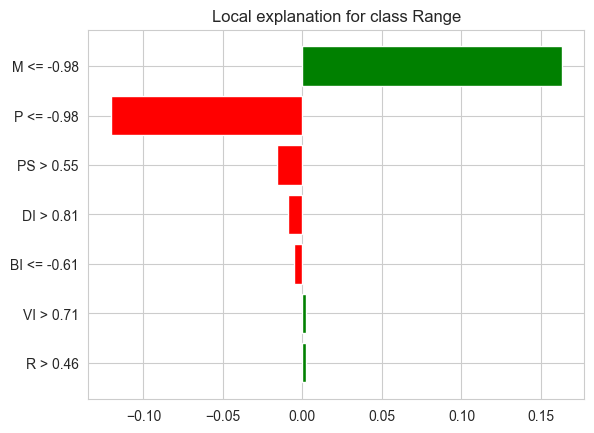

In [21]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_normalized.values, mode="classification", 
                                      feature_names=features, class_names=['Short', 'Range', 'Long'], 
                                      discretize_continuous=True)

def lime_predict_proba(data):
    data_df = pd.DataFrame(data, columns=features)
    return model.predict_proba(data_df)

random_index = np.random.randint(0, len(X_normalized))
exp = lime_explainer.explain_instance(X_normalized.iloc[random_index].values, lime_predict_proba, num_features=len(features))

exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.show()

In [51]:
from sklearn.ensemble import RandomForestClassifier

k_folds = 5

rf_model = RandomForestClassifier(random_state=seed)

perform_kfold_cv(rf_model, X_normalized, y, k_folds)

rf_imp = pd.DataFrame({
    "feature": X_normalized.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head(10)

,feature,importance
0,P,0.427366
1,M,0.370822
2,DI,0.071328
3,R,0.068796
4,VI,0.025244
5,BI,0.019699
6,PS,0.016746


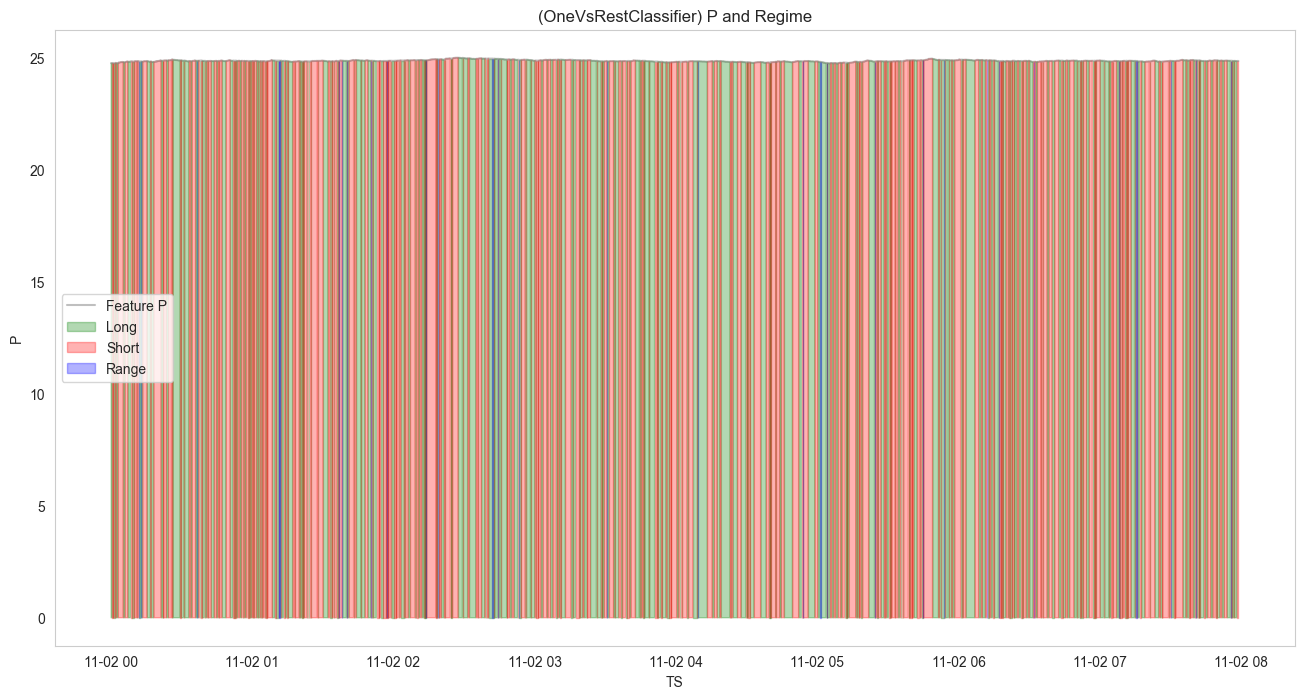

In [23]:
dpred = df_l.loc[X_normalized.index].copy()
dpred['regime'] = predictions

plot_regime(dpred, model.__class__.__name__)

In [57]:
import numpy as np
from scipy.optimize import minimize

class HawkesProcess:
    def __init__(self, mu=0.1, alpha=0.5, beta=1.0, reg_alpha=1e-2, reg_beta=1e-2):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.event_times = []
        self.reg_alpha = reg_alpha
        self.reg_beta = reg_beta

    def intensity(self, t):
        if not self.event_times:
            return self.mu

        time_diff = t - np.array(self.event_times)

        return self.mu + np.sum(self.alpha * np.exp(-self.beta * time_diff))

    def simulate(self, T_sim):
        self.event_times = []
        t = 0

        while t < T_sim:
            lambda_t = self.intensity(t)
            x = np.random.exponential(1 / lambda_t)
            t += x
            
            if t < T_sim:
                self.event_times.append(t)

    def fit(self, observed_events):
        if not np.all(np.diff(observed_events) >= 0):
            raise ValueError("observed_events must be sorted in non-decreasing order.")
        
        if np.any(observed_events < 0):
            raise ValueError("observed_events must contain non-negative timestamps.")

        T_max = observed_events[-1] if len(observed_events) > 0 else 1.0
        event_density = len(observed_events) / T_max if T_max > 0 else 0
        
        ada_reg_alpha = self.reg_alpha / (1 + event_density)

        def log_likelihood(params):
            mu, alpha, beta = params
            ll = 0

            for t_k in observed_events:
                previous_events = observed_events[observed_events < t_k]
                previous_events = np.array(previous_events, dtype=np.float64)
                
                if len(previous_events) > 0:
                    decay_terms = alpha * np.exp(-beta * (t_k - previous_events))
                    lambda_t_k = mu + np.sum(decay_terms)
                else:
                    lambda_t_k = mu
                
                if lambda_t_k <= 0:
                    return np.inf
                
                ll += np.log(lambda_t_k)

            ll -= mu * T_max + (alpha / beta) * np.sum(1 - np.exp(-beta * (T_max - observed_events)))
            ll -= ada_reg_alpha * alpha**2 + self.reg_beta * beta**2

            return -ll

        initial_params = [self.mu, self.alpha, self.beta]
        bounds = [(1e-8, None), (1e-8, None), (1e-8, None)]

        result = minimize(log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')
        
        print(f"Success: {result.success}, {result.message}")

        self.mu, self.alpha, self.beta = result.x


In [75]:
def create_prob_edge_index(event_times, mu=0.1, alpha=0.5, beta=1.0, sigmoid_scaling=0.5, exp_cap=1e6):
    n = len(event_times)

    event_times_tensor = event_times if isinstance(event_times, torch.Tensor) else torch.tensor(event_times, dtype=torch.float32)
    
    time_matrix = event_times_tensor.unsqueeze(1) - event_times_tensor.unsqueeze(0)
    mask = torch.tril(torch.ones_like(time_matrix), diagonal=-1).bool()
    
    intensities = torch.zeros((n, n), dtype=torch.float32)
    exp_terms = torch.exp(-beta * time_matrix[mask]).clamp(max=exp_cap).to(intensities.dtype)
    intensities[mask] = mu + alpha * exp_terms

    min_intensity, max_intensity = intensities.min(), intensities.max()
    intensities = (intensities - min_intensity) / (max_intensity - min_intensity + 1e-6)
    
    probabilities = torch.sigmoid(sigmoid_scaling * intensities)
    
    random_values = torch.rand((n, n))
    selected_edges = (random_values < probabilities) & mask
    
    edge_list = selected_edges.nonzero(as_tuple=False).t()
    edge_weights = probabilities[selected_edges]
    
    assert edge_list.shape[1] == edge_weights.shape[0], "Mismatch between edge_list and edge_weights."
    
    return edge_list, edge_weights

In [76]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

BATCH_SIZE = 32
TEST_RATIO = 0.2
MU = 0.1
ALPHA = 0.5
BETA = 1.0

event_times = torch.tensor(timestamps.to_numpy().astype(float), dtype=torch.float64)
y_mapped = y.replace({-1: 2})

h = HawkesProcess(MU, ALPHA, BETA)
h.fit(event_times.numpy())

print(f"Hawkes with mu: {h.mu} alpha: {h.alpha} beta: {h.beta}")

sampler = NeighbourhoodCleaningRule()
X_sampled, y_sampled = sampler.fit_resample(X_normalized.to_numpy(), y_mapped.values)
event_times_sampled = event_times[sampler.sample_indices_]

X_t = torch.tensor(X_sampled, dtype=torch.float)
y_t = torch.tensor(y_sampled, dtype=torch.long)

X_train, X_test, y_train, y_test, event_times_train, event_times_test = train_test_split(
    X_t, y_t, event_times_sampled, test_size=TEST_RATIO, random_state=seed, stratify=y_t
)

train_data_list, test_data_list = [], []

def create_graph_samples(X, y, event_times, batch_size=BATCH_SIZE):
    data_list = []

    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        event_times_batch = event_times[i:i + batch_size]
        
        edge_index, edge_attr = create_prob_edge_index(event_times_batch, mu=h.mu, alpha=h.alpha, beta=h.beta)
        
        data = Data(x=X_batch, edge_index=edge_index, edge_attr=edge_attr, y=y_batch)
        data_list.append(data)
    
    return data_list

train_data_list = create_graph_samples(X_train, y_train, event_times_train)
test_data_list = create_graph_samples(X_test, y_test, event_times_test)

train_dataloader = DataLoader(train_data_list, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=1)

Success: True, CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Hawkes with mu: 1e-08 alpha: 1e-08 beta: 1.1826919101943718


In [77]:
batch = next(iter(train_dataloader))

print("Node features (X):", batch.x.shape)
print("Edge index:", batch.edge_index.shape)
print("Edge attr:", batch.edge_attr.shape)
print("y:", batch.y.shape)
print("batch:", batch.batch)

Node features (X): torch.Size([32, 7])
Edge index: torch.Size([2, 300])
Edge attr: torch.Size([300])
y: torch.Size([32])
batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [167]:
import torch
from torch_geometric.nn import GATConv
from torch import nn
import torch.nn.functional as F

class JumpDiffusionLayer(nn.Module):
    def __init__(self, jump_intensity, jump_scale, volatility=0.1, learnable=True):
        super(JumpDiffusionLayer, self).__init__()
        self.jump_intensity = nn.Parameter(torch.tensor(jump_intensity), requires_grad=learnable)
        self.jump_scale = nn.Parameter(torch.tensor(jump_scale), requires_grad=learnable)
        self.volatility = nn.Parameter(torch.tensor(volatility), requires_grad=learnable)

    def forward(self, x):
        prev_close = x[-2, :].unsqueeze(0)

        high = x.max(dim=0).values
        low = x.min(dim=0).values
        true_range = torch.max(high - low, torch.max(torch.abs(high - prev_close), torch.abs(low - prev_close)))

        current_volatility = torch.mean(true_range)

        adj_jump_intensity = self.jump_intensity * current_volatility / self.volatility
        adj_jump_intensity = torch.clamp(adj_jump_intensity, 0, 1)

        mean = torch.zeros_like(x)
        
        std = F.relu(self.jump_scale * self.volatility) * torch.ones_like(x)

        jumps = torch.poisson(adj_jump_intensity * torch.ones_like(x)) * torch.normal(mean, std)

        return x + F.elu(jumps) * self.jump_intensity


class SelfAttentionPooling(nn.Module):
    def __init__(self, in_dim, heads=8, dropout=0.1):
        super(SelfAttentionPooling, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=in_dim, num_heads=heads, dropout=dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.permute(1, 0, 2)

        attn_output, _ = self.att(x, x, x)
        pooled_output = attn_output.mean(dim=0)
        return pooled_output


class FusionLayer(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels, attention_heads=4, dropout=0.1):
        super(FusionLayer, self).__init__()

        self.fc1_1d = nn.Linear(in_channels1, out_channels)
        self.fc2_2d = nn.Linear(in_channels2, out_channels)

        self.cross_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        
        self.fc_fuse1 = nn.Linear(out_channels * 2, out_channels)
        self.fc_fuse2 = nn.Linear(out_channels, out_channels)
        self.dropout = nn.Dropout(dropout)

        self.residual_1d = nn.Linear(in_channels1, out_channels)
        self.residual_2d = nn.Linear(in_channels2, out_channels)

    def forward(self, x1d, x2d):
        x1d = x1d.view(x1d.size(0), -1)
        x2d = x2d.view(x2d.size(0), -1)

        x1d_transformed = F.relu(self.fc1_1d(x1d))
        x2d_transformed = F.relu(self.fc2_2d(x2d))

        x1d_transformed = x1d_transformed.unsqueeze(0)
        x2d_transformed = x2d_transformed.unsqueeze(0)

        fused, _ = self.cross_attention(x1d_transformed, x2d_transformed, x2d_transformed)
        fused = fused.squeeze(0)

        fused = torch.cat((fused, x1d_transformed.squeeze(0)), dim=1)
        fused = F.relu(self.fc_fuse1(fused))
        fused = self.dropout(fused)
        fused = self.fc_fuse2(fused)

        x1d_residual = F.relu(self.residual_1d(x1d))
        x2d_residual = F.relu(self.residual_2d(x2d))
        fused = fused + x1d_residual + x2d_residual

        return fused
    
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.1):
        super(GNNLayer, self).__init__()
        self.gat_conv = GATConv(in_channels, out_channels, heads=heads, dropout=dropout)

    def forward(self, x, edge_index, edge_attr):
        x_gat = self.gat_conv(x, edge_index, edge_attr=edge_attr)
        return x_gat

class ORCA(nn.Module):
    def __init__(self, in_channels, conv_out_channels, gat_heads=4, gat_dropout=0.1, classes=3, jump_intensity=0.1, jump_scale=0.05):
        super(ORCA, self).__init__()

        self.conv_block1_2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=conv_out_channels, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.residual1 = nn.Conv2d(in_channels, conv_out_channels, kernel_size=1)

        self.conv_block2_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 2), stride=(1, 1), padding=(0, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(2, 1), stride=(1, 1), padding=(1, 0)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.conv_block3_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.residual3 = nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=1, stride=2)

        self.conv_block1_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=3, padding=1),
            nn.Mish(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block2_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=5, padding=2),
            nn.SELU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block3_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=7, padding=3),
            nn.SiLU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block4_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=9, padding=4),
            nn.GELU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        
        self.fusion_layer = FusionLayer(conv_out_channels, conv_out_channels, conv_out_channels)

        self.jump_diffusion = JumpDiffusionLayer(jump_intensity, jump_scale)

        self.gnn_layer = GNNLayer(in_channels, conv_out_channels, gat_heads, gat_dropout)

        self.fd1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(conv_out_channels, classes)

        self.apply(self._init_weights)

    def forward(self, x, edge_index, edge_attr):
        x1 = x.unsqueeze(1).transpose(1, 2)
        x2 = x1.unsqueeze(2)

        residual1 = self.residual1(x2)
        x2d = self.conv_block1_2d(x2) + residual1

        residual2 = x2d
        x2d = self.conv_block2_2d(x2d) + residual2

        residual3 = self.residual3(x2d)
        x2d = self.conv_block3_2d(x2d) + residual3

        x1d1 = self.conv_block1_1d(x1)
        x1d2 = self.conv_block2_1d(x1)
        x1d3 = self.conv_block3_1d(x1)
        x1d4 = self.conv_block4_1d(x1)

        x1d = torch.cat((x1d1, x1d2, x1d3, x1d4), dim=1)

        x_fused = self.fusion_layer(x1d, x2d)
        x_jump = self.jump_diffusion(x_fused)

        x_gnn = self.gnn_layer(x, edge_index, edge_attr)

        x_fc = self.fd1(x_jump)
        x_fc = x_fc.view(x_fc.size(0), -1)
        x_fc = F.relu(self.fc1(x_fc))
        
        return x_fc
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.LayerNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [168]:
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)

        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        return F_loss

In [169]:
import torch.optim as optim
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 100

model = ORCA(in_channels=X_train.shape[1], conv_out_channels=64, gat_heads=8)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
criterion = FocalLoss()

snapshot_manager = SnapshotManager(model, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)

In [170]:
import gc
from notebooks.train import Trainer

class ORCATrainer(Trainer):
    def __init__(self, *args, acc_steps=4, l1_lambda=0.001, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps
        self.l1_lambda = l1_lambda

    def compute_l1_loss(self):
        l1_loss = 0.0

        for param in self.model.parameters():
            l1_loss += torch.sum(torch.abs(param))
        
        return self.l1_lambda * l1_loss
    
    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            output = self.model(batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_attr.to(self.device))

            loss = self.criterion(output, batch.y.to(self.device)) / self.acc_steps
            l1_loss = self.compute_l1_loss()
            
            total_loss = loss + l1_loss

            acc_loss += loss.item()

            total_loss.backward()

            if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                self.optimizer.step()
                self.optimizer.zero_grad()
                running_train_loss += acc_loss
                acc_loss = 0.0

            del batch, output, loss

            if (batch_idx + 1) % (self.acc_steps * 5) == 0:
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()
                elif torch.cuda.is_available():
                    torch.cuda.empty_cache()

                gc.collect()

        if acc_loss > 0:
            running_train_loss += acc_loss

        num_updates = (num_batches + self.acc_steps - 1) // self.acc_steps
        avg_train_loss = running_train_loss / num_updates if num_updates > 0 else float("inf")

        return avg_train_loss

    def valid_epoch(self):
        self.model.eval()
        running_val_loss = 0.0
        num_batches = len(self.test_dataloader)
        acc_loss = 0.0

        with torch.no_grad():
            for batch_idx, batch in enumerate(self.test_dataloader):
                output = self.model(batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_attr.to(self.device))
                loss = self.criterion(output, batch.y.to(self.device)) / self.acc_steps
                acc_loss += loss.item()

                if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                    running_val_loss += acc_loss
                    acc_loss = 0.0

        if acc_loss > 0:
            running_val_loss += acc_loss

        num_updates = (num_batches + self.acc_steps - 1) // self.acc_steps
        avg_val_loss = running_val_loss / num_updates if num_updates > 0 else float("inf")

        return avg_val_loss


In [171]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

trainer = ORCATrainer(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    scheduler,
    criterion,
    early_stop,
    checkpoint,
    device=device,
)


Loaded snapshot: snapshots/ORCA_epoch_1_improved.pth


In [172]:
trainer.train(1)

Start training with epochs 1
Epoch 1/1, Train_Loss: 0.0547, Val_Loss: 0.0493
Saved improved snapshot: snapshots/ORCA_epoch_1_improved.pth
Training Complete


In [173]:
def evaluate_model(model, dataloader, replace_class={2: -1}):
    model.eval()
    
    all_predictions = []
    all_probabilities = []
    all_y_true = []
    
    with torch.no_grad():
        for batch in dataloader:
            output = model(batch.x, batch.edge_index, batch.edge_attr)
            prob = torch.softmax(output, dim=1)
            
            pred = prob.argmax(dim=1)
            all_predictions.append(pred.cpu())
            all_probabilities.append(prob.cpu())
            all_y_true.append(batch.y.cpu())
    
    predictions = torch.cat(all_predictions).numpy()
    probabilities = torch.cat(all_probabilities).numpy()
    y_true = torch.cat(all_y_true).numpy()
    
    for orig, new in replace_class.items():
        predictions = np.where(predictions == orig, new, predictions)
        y_true = np.where(y_true == orig, new, y_true)
    
    return predictions, probabilities, y_true

Accuracy: 0.9617
Precision: 0.9611
Recall: 0.9617
F1 Score: 0.9558
Brier Score: 0.0478
ROC-AUC Score: 0.2147
Hamming: 0.0383


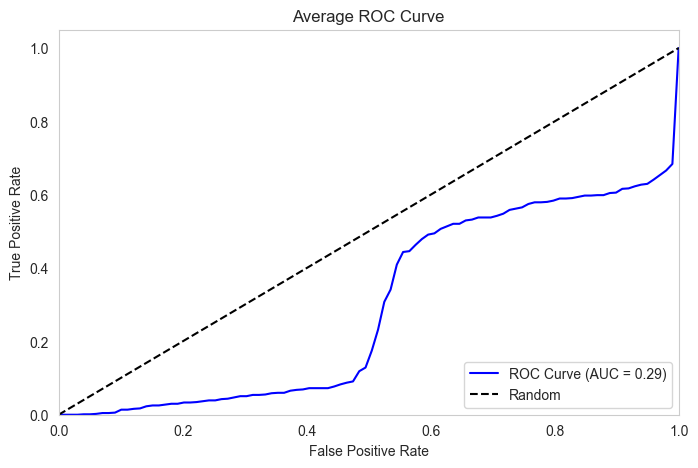

In [177]:
inf_model = ORCA(in_channels=X_train.shape[1], conv_out_channels=64, gat_heads=8)
snapshot_path = os.path.join('snapshots', 'ORCA_epoch_1_improved.pth')

inf_model.load_state_dict(
    torch.load(snapshot_path, map_location="cpu", weights_only=True)
)

predictions, probabilities, y_true = evaluate_model(inf_model, test_dataloader)

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, y_true)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, y_true)